# ensemble learning XGBoost

In [9]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import re, pip, conda
import time
import os

d:\CODE\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Three elements of Boosting:

- Loss function $L(y,\hat{y})$: used to measure the difference between the model prediction results and the real results. <br>
- Weak evaluator $f(x)$: (generally) decision tree, different boosting algorithms use different tree building processes. <br>
- Comprehensive integration result $H(x)$: that is, how the integration algorithm specifically outputs the integration result

 **The balance between the learning ability of the tree model and the risk of overfitting is the balance between prediction accuracy and model complexity, as well as the balance between empirical risk and structural risk**


> - **1. XGBoost adds a structural risk term to the loss function $L(y,\hat{y})$ to form the objective function $O(y,\hat{y})$**<br><br>
> In AdaBoost and GBDT, our goal is to find the minimum value of the loss function $L(y,\hat{y})$, that is, to minimize the difference between the predicted results and the real results. This process only cares about accuracy, not Care about complexity and overfitting. In order to deal with this problem, XGBoost draws experience from the pre-pruning process of decision trees, the anti-overfitting process of classic algorithms such as logistic regression, ridge regression, and Lasso, and adds a structural risk term to control overfitting to the loss function, and Define [$L(y,\hat{y})$ + structural risk] as the objective function $O(y,\hat{y})$. <br><br>
> This change makes XGBoost different from other Boosting algorithms in many aspects: for example, XGBoost trains toward the goal of minimizing the objective function, rather than minimizing the loss function. For another example, XGBoost will give priority to using parameters in structural risk to control overfitting, unlike other tree ensemble models that rely on tree structure parameters (such as `max_depth`, `min_impurity_decrease`, etc.). <br><br>
> - **2. Use a new impurity metric to incorporate complexity into branching rules**<br><br>
> Among the algorithms we have learned before, no matter how the Boosting process evolves, the rules for building a single decision tree basically follow the CART tree process we have learned. In the classification tree, we use information gain to measure the leaves. In regression trees, we use MSE or Friedman MSE to measure the quality of leaves. This process has a mature pruning mechanism, high prediction accuracy, and can adapt to various scenarios, but it may build a tree with high complexity. <br><br>
> In order to achieve a balance between accuracy and complexity, XGBoost resets the branching index **[Structure Score]** (written as Structure Score in the original paper, also known as Quality Score), and based on the structure The gain of structure score can force the decision tree to grow toward a simpler overall structure. <br><br>
> This change allows XGBoost to use a tree-building process that is slightly different from traditional CART. At the same time, a large number of residuals or residual-like objects are used as intermediate variables in the tree-building process, so the mathematical process of XGBoost is more complex than other Boosting algorithms.

- **Second, greatly reduce model complexity, improve model operating efficiency, and arm the algorithm into one more suitable for big data**
在任意决策树的建树过程中，都需要对每一个特征上所有潜在的分枝节点进行不纯度计算，当数据量巨大时，这一计算将消耗巨量的时间，因此树集成模型的关键缺点之一就是计算缓慢，而这一缺点在实际工业环境当中是相当致命的。为了提升树模型的运算速度、同时又不极大地伤害模型的精确性，XGBoost使用多种优化技巧来实现效率提升：<br>

> - **1. 使用估计贪婪算法、平行学习、分位数草图算法等方法构建了适用于大数据的全新建树流程**<br><br>
> - **2. 使用感知缓存访问技术与核外计算技术，提升算法在硬件上的运算性能**<br><br>
> - **3. 引入Dropout技术，为整体建树流程增加更多随机性、让算法适应更大数据**<br>

XGBoost also retains some properties similar to gradient boosting trees, including:

- **The output type of the weak evaluator is inconsistent with the output type of the ensemble algorithm**

> For the AdaBoost or random forest algorithm, when the ensemble algorithm performs a regression task, the weak evaluator is also a regressor, and when the ensemble algorithm performs a classification task, the weak evaluator is also a classifier. But for GBDT and complex Boosting algorithms based on GBDT, regardless of whether the integrated algorithm is performing regression/classification/sorting tasks as a whole, the weak evaluator must be a regressor**. GBDT outputs specific classification results through the sigmoid or softmax function, but the actual weak evaluator must be a regressor, and the same is true for XGBoost.

- **Fit negative gradient, and when the loss function is 0.5 times MSE, the fitting residual**

> Any Boosting algorithm has the step of adaptively adjusting the weak estimator. In GBDT, what is used to build a weak estimator each time is the sample $X$ and the pseudo-residual difference (that is, the negative gradient) between the current integrated output $H(x_i)$ and the real label $y$. When the loss function is $\frac{1}{2}MSE$, the negative gradient is mathematically equivalent to the residual (Residual), so **GBDT affects the subsequent weak evaluator structure by fitting the residual**. XGBoost also relies on fitting residuals to affect the subsequent weak estimator structure, but like GBDT, this needs to be proven mathematically.

- **Sampling Thoughts**

> GBDT draws on a large number of sampling ideas from the Bagging algorithm, and XGBoost also inherits this attribute. Therefore, in XGBoost, we can also sample samples and features to increase the independence between weak evaluators.

Because of these similarities, we will see some familiar parameters in the parameters of XGBoost. If you are familiar with gradient boosting trees, many parameters of XGBoost should not be difficult to understand for you. It should be noted that, as a Boosting algorithm that was only officially proposed in 2014, XGBoost is an algorithm system independent of the classic algorithm, so the xgboost library needs to be installed separately.

In [ ]:
#!pip install xgboost #安装xgboost库
#!pip install --upgrade xgboost #更新xgboost库

In [10]:
import xgboost as xgb 

In [4]:
xgb.__version__

'2.0.3'

---

- # XGBoost regression

|类|说明|
|:-:|:-:|
|**XGBRegressor()**|实现xgboost回归|
|**XGBClassifier()**|实现xgboost分类|
|**XGBRanker()**|实现xgboost排序|
|**XGBRFClassifier()**|基于xgboost库实现随机森林分类|
|**XGBRFRegressor()**|基于xgboost库实现随机森林回归|

In [5]:
from xgboost import XGBRegressor 
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split

In [11]:
data = pd.read_csv(r"D:\Practice\Machine Learning\datasets\House Price\train_encode.csv", index_col=0)

In [12]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [9]:
X.shape

(1460, 80)

In [10]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=21)

xgb_sk = XGBRegressor(random_state=21)
xgb_sk.fit(Xtrain,Ytrain)
xgb_sk.score(Xtest, Ytest)

0.7681827467348319

In [12]:
xgb_sk = XGBRegressor(random_state=21)

In [13]:
cv = KFold(n_splits=5, shuffle=True,random_state=21)

result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv,
                               scoring="neg_root_mean_squared_error",
                               return_train_score=True,
                               verbose=True,
                               n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


In [14]:
result_xgb_sk

{'fit_time': array([0.60022521, 0.569098  , 0.59541702, 0.57928467, 0.54183531]),
 'score_time': array([0.01377916, 0.00521708, 0.00480819, 0.01613235, 0.01572061]),
 'test_score': array([-30324.87678271, -31122.22065422, -28712.33078882, -21450.69418462,
        -27141.45317631]),
 'train_score': array([-809.77246182, -684.66269697, -883.50186146, -875.8521187 ,
        -974.72531804])}

In [15]:
def RMSE(result, name):
    return abs(result[name].mean())

In [16]:
RMSE(result_xgb_sk,"train_score")

845.7028913981958

In [17]:
RMSE(result_xgb_sk,"test_score")

27750.315117336217

In [19]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412).fit(X,y)
xgb_sk.feature_importances_

array([8.26333184e-04, 2.12834612e-03, 8.12532101e-03, 1.54485530e-03,
       3.29265394e-03, 0.00000000e+00, 0.00000000e+00, 1.04166195e-02,
       8.34375247e-03, 0.00000000e+00, 6.22954394e-04, 5.31205384e-04,
       9.73080005e-03, 9.57744254e-04, 2.16878587e-04, 4.28955769e-04,
       3.75213567e-04, 3.67699683e-01, 5.65355876e-03, 7.52156600e-03,
       4.85523697e-03, 6.16654288e-04, 3.88299959e-04, 2.42258189e-03,
       6.88124448e-04, 2.03368231e-03, 1.36517768e-03, 9.92153585e-03,
       8.29061551e-04, 4.28547821e-04, 3.72072458e-02, 1.12599344e-03,
       1.68225938e-03, 1.37483701e-03, 1.07332589e-02, 6.06742804e-04,
       4.89910948e-04, 1.04227941e-03, 2.09216047e-02, 0.00000000e+00,
       1.42600539e-03, 1.32163782e-02, 3.49702721e-04, 9.48428456e-03,
       1.59472823e-02, 6.03948080e-04, 4.15862463e-02, 3.98524664e-03,
       1.28499628e-03, 7.59406528e-03, 1.72022637e-03, 2.81421118e-03,
       1.25269502e-01, 5.51205017e-02, 4.16176580e-03, 3.74213257e-03,
      

In [20]:
xgb_sk.get_booster()[2]

In [21]:
xgb_sk.get_num_boosting_rounds()

100

In [22]:
xgb_sk.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 1412,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

---

### Native code implementation of XGBoost regression

**Native code must use XGBoost’s custom data structure DMatrix**. This data structure can ensure that the xgboost algorithm runs faster and can be naturally migrated to run on the GPU. Structures such as lists, arrays, and Dataframes cannot be used. Native code, so the first step in using native code is to replace the data structure.

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(*params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

*function* `xgboost.cv`(*params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

-Convert data to DMatrix

In [23]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [24]:
data_xgb = xgb.DMatrix(X,y)

In [25]:
data_xgb

In [26]:
type(data_xgb)

xgboost.core.DMatrix

In [27]:
data_xgb[0]

TypeError: 'DMatrix' object is not subscriptable

In [28]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [29]:
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

In [30]:
params = {"max_depth":5, "seed":21}

In [31]:
reg = xgb.train(params, data_xgb, num_boost_round=100)

In [32]:
params = {"num_boost_round":100,"max_depth":5,"seed":1412}
reg = xgb.train(params, data_xgb)

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


In [33]:
y_pred = reg.predict(data_xgb)
y_pred

array([192319.78, 164022.9 , 214549.73, ..., 252041.53, 137165.7 ,
       149061.48], dtype=float32)

In [35]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False)

15808.834219614408

In [36]:
params = {"max_depth":5, "seed":21}
result = xgb.cv(params,data_xgb,num_boost_round=100,
                nfold=5,
                seed=21)

In [37]:
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,60407.440564,775.323852,61958.720138,3101.365692
1,46916.424100,632.389252,50230.884495,2666.308721
2,37380.302022,388.816593,42602.758725,2967.382971
3,30545.218617,324.799826,37610.212116,2815.912726
4,25584.269884,299.427683,34395.495393,2854.163918
...,...,...,...,...
95,2411.859324,169.804205,28009.412688,3915.186244
96,2362.420789,153.980358,28011.563637,3923.116978
97,2323.544040,159.753160,28008.789517,3926.267356
98,2290.508689,163.230855,28015.371320,3926.801498


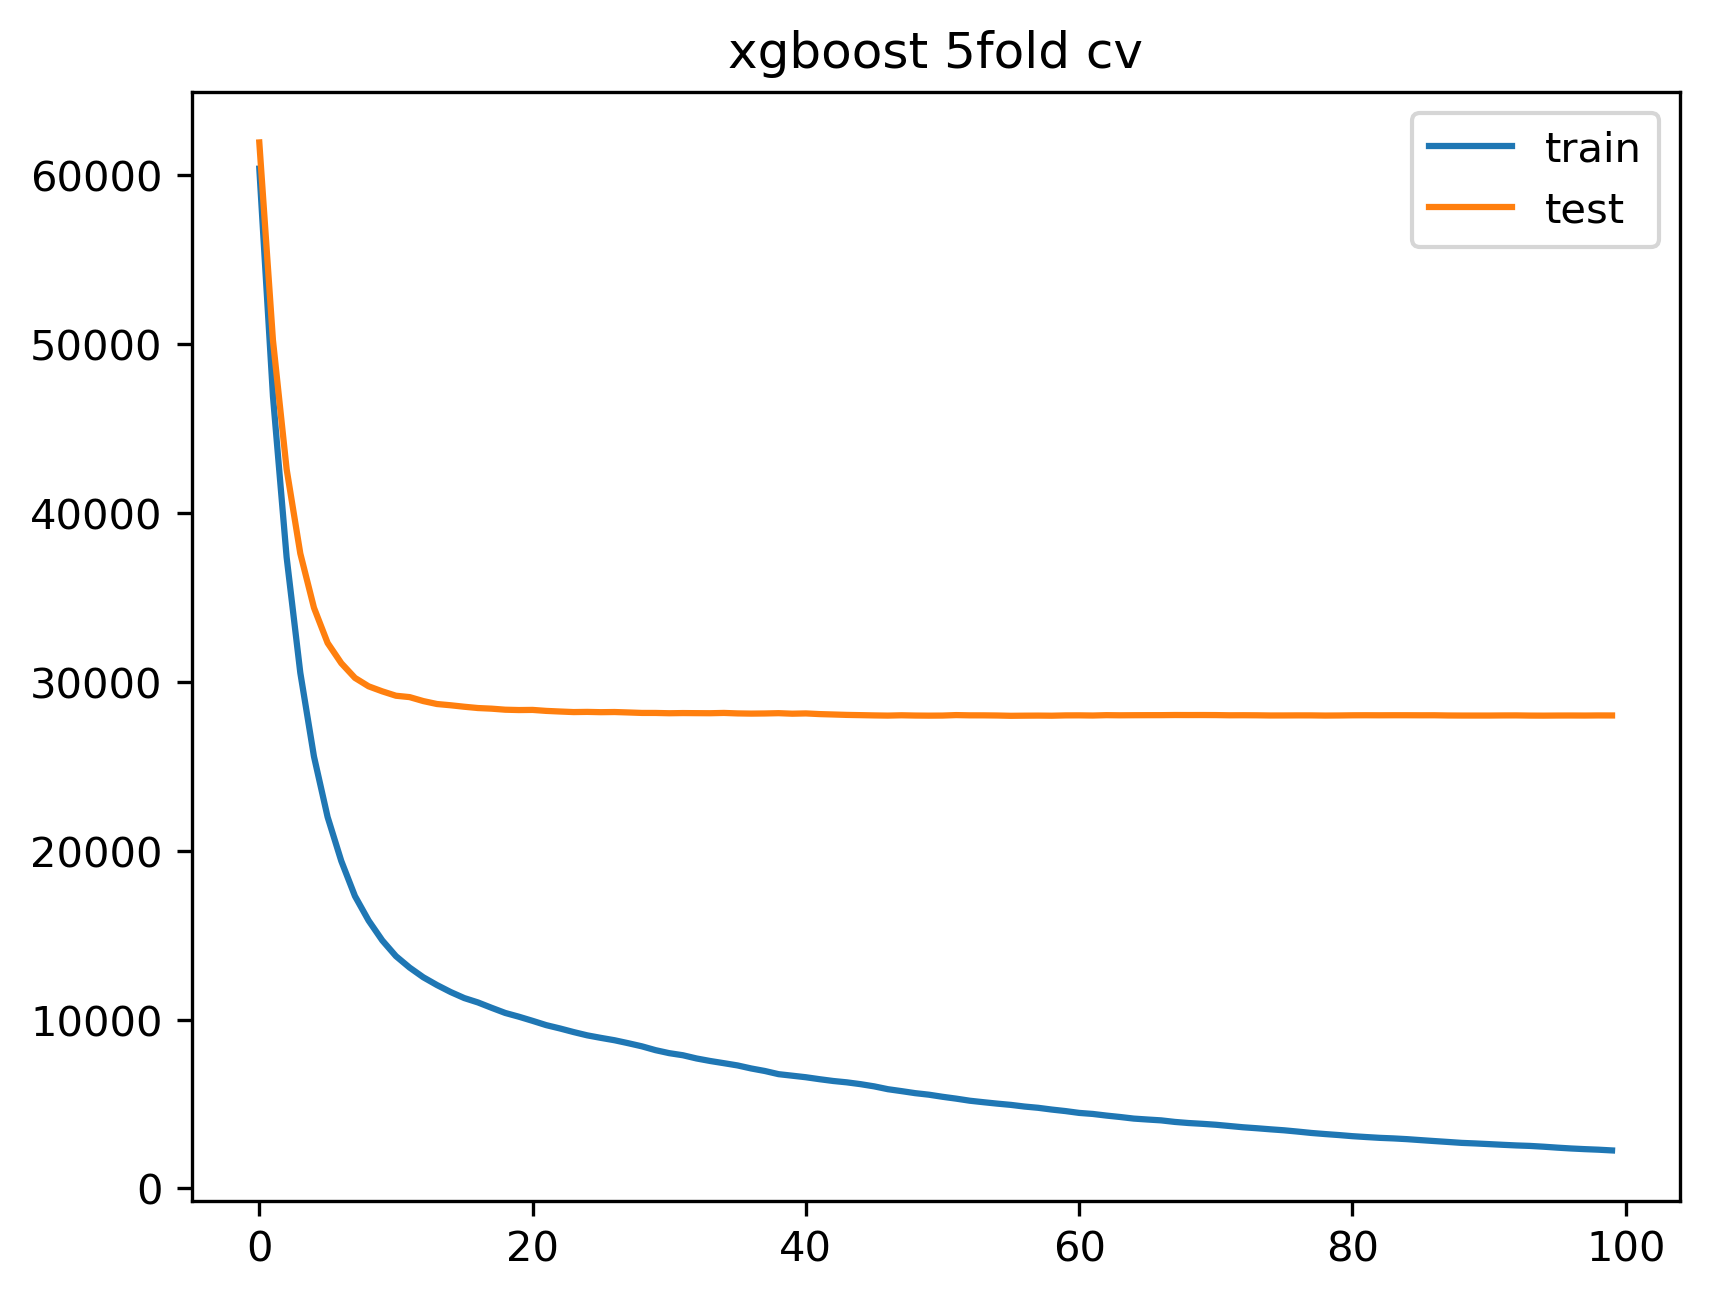

In [38]:
plt.figure(dpi=300)
plt.plot(result["train-rmse-mean"])
plt.plot(result["test-rmse-mean"])
plt.legend(["train","test"])
plt.title("xgboost 5fold cv");

---

### xgboost clasification

XGBoost implements the regression algorithm by default, so when performing classification, we need to actively declare the type of algorithm. xgboost determines the task type through the loss function used by the current algorithm, that is, through the `objective` parameters filled in params to determine the task type. When the regression task is no longer performed, the evaluation indicators of the model will also change, so xgboost classification will require more parameters. Dozens of different options can be entered in the `objective` parameter, the common ones are:

- for regression
> - **reg:squarederror**: squared loss, that is, $\frac{1}{2}(y - \hat{y})^2$, where 1/2 is for simplicity of calculation<br><br>
> - **reg:squaredlogerror**: Squared logarithm loss, that is, $\frac{1}{2}[log(\hat{y} + 1) - log(y + 1)]^2$, where 1 /2 is for ease of calculation

- for classification
> - **binary:logistic**: binary cross-entropy loss. When using this loss, the `predict` interface outputs the probability. If you are not familiar with this loss, you will need to learn the logistic regression algorithm. <br><br>
> - **binary:logitraw**: binary cross-entropy loss. When using this loss, `predict` will output the value before performing the sigmoid change<br><br>
> - **multi:softmax**: Multi-class cross entropy loss. When using this loss, the `predict` interface outputs specific categories. If you are not familiar with this loss, you need to learn AdaBoost and GBDT. <br><br>
> - **multi:softprob**: Multi-class cross entropy, when this loss is applied, the `predict` interface outputs the probability of each category of each sample

In addition, there are many loss functions used in sorting algorithms and counting algorithms. xgboost is suitable for almost all differentiable loss functions. Different loss functions will affect the output of `predict`, but will not affect the output of the cross-validation method `xgb.cv`. When nothing is filled in, the default value of the parameter `objective` is `reg:squarederror`. Next let's take a look at the implementation of the xgboost classifier:

In [39]:
from sklearn.datasets import load_breast_cancer, load_digits

X_binary = load_breast_cancer().data
y_binary = load_breast_cancer().target
data_binary = xgb.DMatrix(X_binary, y_binary)

X_multi = load_digits().data
y_multi = load_digits().target
data_multi = xgb.DMatrix(X_multi, y_multi)

In [40]:
params1 = {"seed":21, "objective":"binary:logistic",
           "eval_metric":"logloss"
           }
clf_binary = xgb.train(params1, data_binary, num_boost_round=100)

In [41]:
params2 = {"seed":21, "objective":"multi:softmax",
           "eval_metric":"mlogloss",
           "num_class":10}
clf_multi = xgb.train(params2, data_multi, num_boost_round=100)

In [42]:
y_pred_binary = clf_binary.predict(data_binary)

In [43]:
y_pred_multi = clf_multi.predict(data_multi)

In [44]:
y_pred_binary[:20]

array([5.9830486e-03, 1.0785054e-03, 2.8278260e-04, 1.7240757e-02,
       8.8689197e-03, 2.0348135e-02, 8.1676582e-05, 4.3557968e-04,
       1.5153858e-03, 5.1954496e-03, 1.1665462e-02, 3.4424273e-04,
       7.8352279e-04, 6.0624103e-03, 1.3893890e-02, 4.8467741e-04,
       9.8429613e-05, 1.8938415e-04, 1.3668074e-04, 9.9775141e-01],
      dtype=float32)

In [45]:
y_pred_multi 

array([0., 1., 2., ..., 8., 9., 8.], dtype=float32)

In [47]:
from sklearn.metrics import accuracy_score as ACC #当返回具体类别时，可以使用准确率
from sklearn.metrics import log_loss as logloss #当返回概率时，则必须使用交叉熵损失

In [48]:
(y_pred_binary > 0.5).astype("int")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [49]:
ACC(y_binary,(y_pred_binary > 0.5).astype(int)) #对二分类计算准确率，则必须先转换为类别

1.0

In [50]:
ACC(y_multi, y_pred_multi)

1.0

In [51]:
logloss(y_binary,y_pred_binary) #只有二分类输出了概率，因此可以查看交叉熵损失

0.004643990703670779

In [52]:
params2 = {"seed":21
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params2,data_multi,num_boost_round=100
                ,metrics = ("mlogloss") #交叉验证的评估指标由cv中的参数metrics决定
                ,nfold=5 
                ,seed=21 
                )

In [53]:
result

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.228107,0.001116,1.321186,0.014580
1,0.870656,0.000678,1.005905,0.018784
2,0.643234,0.001704,0.800929,0.016008
3,0.484985,0.001172,0.655639,0.017381
4,0.370800,0.001917,0.548040,0.019544
...,...,...,...,...
95,0.003914,0.000007,0.103018,0.022063
96,0.003903,0.000007,0.102995,0.022097
97,0.003892,0.000008,0.103033,0.022146
98,0.003882,0.000008,0.102920,0.022162


In [54]:
params3 = {"seed":21
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params3,data_multi,num_boost_round=100
                ,metrics = ("mlogloss","merror")
                ,nfold=5 
                ,seed=21 
                )

In [55]:
result

,train-mlogloss-mean,train-mlogloss-std,train-merror-mean,train-merror-std,test-mlogloss-mean,test-mlogloss-std,test-merror-mean,test-merror-std
0,1.228107,0.001116,0.029634,0.004378,1.321186,0.014580,0.116291,0.015276
1,0.870656,0.000678,0.013774,0.003279,1.005905,0.018784,0.092365,0.011769
2,0.643234,0.001704,0.008487,0.002388,0.800929,0.016008,0.079571,0.005649
3,0.484985,0.001172,0.005148,0.001433,0.655639,0.017381,0.074006,0.006891
4,0.370800,0.001917,0.002922,0.000682,0.548040,0.019544,0.066770,0.006739
...,...,...,...,...,...,...,...,...
95,0.003914,0.000007,0.000000,0.000000,0.103018,0.022063,0.032275,0.008354
96,0.003903,0.000007,0.000000,0.000000,0.102995,0.022097,0.031718,0.008891
97,0.003892,0.000008,0.000000,0.000000,0.103033,0.022146,0.032275,0.008354
98,0.003882,0.000008,0.000000,0.000000,0.102920,0.022162,0.032275,0.008354


In [56]:
from xgboost import XGBClassifier

In [57]:
clf = XGBClassifier()

In [58]:
clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [59]:
clf = XGBClassifier(objective="multi:softmax",
                    eval_metric="mlogloss",
                    num_class=10 #,use_label_encoder=False
                    )

In [60]:
clf = clf.fit(X_multi, y_multi)

In [61]:
clf.predict(X_multi)

array([0, 1, 2, ..., 8, 9, 8])

In [62]:
clf.predict_proba(X_multi).shape

(1797, 10)

In [63]:
clf.score(X_multi, y_multi)

1.0

---

### parameters of XGBoost

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)$$

This learning rate parameter controls the growth rate of $H(x_i)$ during the Boosting integration process and is a very critical parameter. When the learning rate is large, $H(x_i)$ grows faster and we need less `num_boost_round`. When the learning rate is small, $H(x_i)$ grows slower and we need `num_boost_round`. ` is more, so the boosting algorithm often needs to make a trade-off between `num_boost_round` and `eta`. In XGBoost, the default value of `num_boost_round` is 10 and the default value of `eta` is 0.3

- `base_score`


When we build our first weak evaluator we have:

$$H_1(x_i) = H_{0}(x_i) + \eta f_1(x_i)$$

Since there is no 0th tree, the value of $H_0(x_i)$ needs to be determined separately during the mathematical process and the specific implementation of the algorithm, and this value is determined by `base_score`. In xgboost, we can output **any value** to `base_score`, but operations similar to the input evaluator in GBDT are not supported. When not filled in, the default value of this parameter is 0.5, that is, 0.5 is set as the starting value for all samples. When the number of iterations is large enough and the amount of data is large enough, it makes little sense to adjust $H_0(x_i)$ of the algorithm, so we basically will not adjust this parameter.
- Parameter `max_delta_step`

During the iteration process, XGBoost has a unique parameter `max_delta_step`. This parameter represents the maximum $\eta f_k(x_i)$ allowed at each iteration. When the parameter `max_delta_step` is set to 0, it means that there is no limit on the size of $\eta f_k(x_i)$ for each iteration. If the parameter is set to a positive number C, it means $\eta f_k(x_i) \leq C$, otherwise let the algorithm execute:

$$H_k(x_i) = H_{k-1}(x_i) + C$$

Usually this parameter is not needed, but sometimes this parameter is effective for extremely imbalanced data. If the sample is extremely unbalanced, you can try setting a number between 1 and 10 in this parameter.

Summarize:

|Parameter meaning|Native code|sklearn API|
|:-:|:-:|:-:|
|Number of iterations/number of trees|**num_boost_round**<br>(xgb.train)|**n_estimators**|
|Learning rate|**eta**<br>(params)|**learning_rate**|
|Initial iteration value|**base_score**<br>(params)|**base_score**|
|The maximum iteration value allowed in an iteration|**max_delta_step**<br>(params)|**max_delta_step**|

---

### Objective function of xgboost

**xgboost runs in the direction that minimizes the objective function**
**But in the definition of XGBoost, the objective function is for each tree, not for a sample or the entire algorithm** For any tree $f_k$, the objective function has two components, one part is arbitrary A micro loss function that controls the **empirical risk** of the model. Numerically speaking, it is equal to the sum of the loss functions on all samples in the current tree, where the loss of a single sample is $l(y_i,\hat{y_i})$. The other part is $\Omega(f_k)$ that controls the complexity of the model, which controls the **structural risk** of the current tree.

$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \Omega(f_k)$
>其中$M$表示现在这棵树上一共使用了M个样本，$l$表示单一样本的损失函数。当模型迭代完毕之后，最后一棵树上的目标函数就是整个XGBoost算法的目标函数。
- **Experiential Risk**: The deeper the model learns from the data, the smaller the loss (the smaller the empirical risk). The more superficially the model learns the data, the greater the loss (the greater the empirical risk).

- **Structural Risk**: The more complex the tree structure and the higher the model complexity, the greater the risk of overfitting (the greater the structural risk). The simpler the tree model structure, the lower the model complexity, and the smaller the risk of overfitting (the smaller the structural risk).
Generally speaking, the model needs to reach a certain complexity to ensure a small loss. However, if you only pursue the smallest empirical risk, it will easily lead to overfitting. On the contrary, if you only pursue low model complexity and low structural risk, the model will easily fall into the dilemma of under-fitting and the loss function will be too high. Therefore, it is very important to balance structural risk and empirical risk. XGBoost operates in the direction of minimizing the objective function, which can ensure that during the iteration process, the empirical risk and structural risk will not become too large, so the loss of the model will not be too great, and at the same time, it will not be too easy to overfit.

---

In the specific formula, the structural risk $\Omega(f_k)$ is composed of two parts. One part is the $\gamma T$ that controls the tree structure, and the other part is the regular term:

$\Omega(f_k) = \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$

Among them, $\gamma$, $\lambda$ and $\alpha$ are coefficients that can be set freely, and $T$ represents the total number of leaves on the current $k$ tree, and $w_j$ represents the current tree. Leaf weights of $j$ leaves. **Leaf weight is a very critical factor in the XGBoost mathematical system. It is actually the predicted value of the current leaf $j$**. This indicator has a greater relationship with the label dimension of the data. Therefore, when the absolute value of the label The larger the value, the larger the value of $w_j$ will tend to be. Therefore, there are two regular terms: the L2 regular term using squares and the L1 regular term using absolute values, so the complete objective function expression is:

$$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{ red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$

It is not difficult to find that all freely set coefficients are related to structural risk. These three coefficients also correspond to the three parameters in xgboost: `gamma`, `alpha` and `lambda`.

- Parameter `gamma`: multiplied by the total number of leaves of a tree $T$, the coefficient that imposes a penalty on the objective function according to the total number of leaves. The default value is 0, and any number between [0, ∞] can be filled in. When the total number of leaves is fixed, the larger `gamma` is, the larger the structural risk term will be; at the same time, when `gamma` is constant, the more total number of leaves and the greater the complexity of the model, the larger the structural risk term will be. In the above two cases, the penalty on the objective function will be greater, so **increasing `gamma` can control overfitting**. <br><br>
- Parameters `alpha` and `lambda`: multiplied before the regular term, the coefficient that imposes a penalty on the objective function according to the size of the leaf weight is the coefficient of the regular term. The default value of `lambda` is 1 and the default value of `alpha` is 0, so xgboost uses L2 regularization by default. Normally, we wouldn't use both regularizers at the same time, but we can try that. $\sum_{j=1}^Tw_j$ is the sum of the output values ​​of all leaves on the current tree, so when there are more leaves on the tree and the complexity of the model becomes greater, $\sum_{j=1}^Tw_j$ The natural value will naturally be larger, so when the regularization coefficient is fixed, the higher the complexity of the model, the heavier the penalty on the overall objective function. When $w$ is fixed, the larger the coefficient of the regular term, the larger the overall objective function. Therefore, increasing `alpha` or `lambda` can control overfitting**.

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|乘在叶子节点数量前的系数|**gamma**<br>(params)|**gamma**|
|L2正则项系数|**lambda**<br>(params)|**reg_lambda**|
|L1正则项系数|**alpha**<br>(params)|**reg_alpha**|

可见，现在`lambda`比`gamma`有效。
|类型|参数|
|---|---|
|**迭代过程/损失函数**|num_boost_round：集成算法中弱分类器数量，对Boosting算法而言为实际迭代次数<br><br>eta：Boosting算法中的学习率，影响弱分类器结果的加权求和过程<br><br><font color="green">**objective**</font>：选择需要优化的损失函数<br><br><font color="green">**base_score**</font>：初始化预测结果$H_0$的设置<br><br><font color="green">**max_delta_step**</font>：一次迭代中所允许的最大迭代值<br><br><font color="green">**gamma**</font>：乘在叶子数量前的系数，放大可控制过拟合<br><br><font color="green">**lambda**</font>：L2正则项系数，放大可控制过拟合<br><br><font color="green">**alpha**</font>：L1正则项系数，放大可控制过拟合|

---

### XGBoost weak estimator

#### three estimator & DART

- `booster`：
> "gbtree","gblinear","dart"

> 输入"gbtree"表示使用遵循XGBoost规则的CART树，我们之前提到的XGBoost在GBDT上做出的改善基本都是针对这一类型的树。这一类型的树又被称为“XGBoost独有树”，XGBoost Unique Tree。<br><br>
> 输入"dart"表示使用抛弃提升树，DART是Dropout Multiple Additive Regression Tree的简称。这种建树方式受深度学习中的Dropout技巧启发，在建树过程中会随机抛弃一些树的结果，可以更好地防止过拟合。在数据量巨大、过拟合容易产生时，DART树经常被使用，但由于会随机地抛弃到部分树，可能会伤害模型的学习能力，同时可能会需要更长的迭代时间。<br><br>
> 输入"gblinear"则表示使用线性模型，当弱评估器类型是"gblinear"而损失函数是MSE时，表示使用xgboost方法来集成线性回归。当弱评估器类型是"gblinear"而损失函数是交叉熵损失时，则代表使用xgboost来集成逻辑回归。<br><br>
> 每一种弱评估器都有自己的params列表，例如只有树模型才会有学习率等参数，只有DART树才会有抛弃率等参数。评估器必须与params中的参数相匹配，否则一定会报错。其中，由于DART树是从gbtree的基础上衍生而来，因此gbtree的所有参数DART树都可以使用。


When a new tree is built in the $k$ th iteration, the result after the iteration is equal to the result of all previous ${k-1}$ trees plus the result of the newly established tree:

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)$$

The DART tree will randomly discard some trees before **each iteration**, that is, these trees will not be involved in the calculation of $H_{k-1}(x_i)$. This method of random abandonment is called "Dropout" . For example, assuming there are 5 trees in total, the results are as follows:

||k=1|k=2|k=3|k=4|k=5|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$\eta f_k(x_i)$|1|0.8|0.6|0.5|0.3|

When building the sixth tree, $H_{k-1}(x_i)$ = 1+0.8+0.6+0.5+0.3 = 3.2 of the ordinary  tree. For the DART tree, we can think of setting the drop rate `rate_drop`. Assuming the drop rate is 0.2, the DART tree will randomly sample one tree from 5 trees and drop it. Assuming that the second tree is abandoned, $H_{k-1}(x_i)$ of the DART tree = 1+0.6+0.5+0.3 = 2.4. By affecting $H_{k-1}(x_i)$, the DART tree affects the loss function and the output result of the entire algorithm $H(x)$, which can greatly affect the entire xgboost in each iteration. direction.

In general anti-overfitting methods, we can only prune the tree in a fancy way from the perspective of the learning ability of a single tree, but the DART tree method controls the overall iterative process. In any algorithm with "iteration" as the core, we all face the same problem, that is, **the initial iteration greatly affects the direction of the entire algorithm, and subsequent iterations can only make minor repairs based on the previous ones**. This is intuitively easy to understand. After all, when we draw the curve of the loss function, we will find that the loss function drops sharply at the beginning of the iteration, but then gradually levels off. In this process, no over-fitting method can affect the process of those trees that are built first and have huge influence, but the DART tree can weaken the influence of these front-end trees and greatly improve the ability to resist over-fitting. .

- Parameter `rate_drop`: the proportion of trees dropped in each iteration
> Set to 0.3, which means 30% of the trees will be dropped. It can only be used when the parameter `booster`="dart" is used. Only floating point numbers between [0.0,1.0] can be filled in. The default value is 0.
- Parameter `one_drop`: at least `one_drop` trees will be discarded in each iteration
> Can be set to any positive integer, such as `one_drop` = 10, which means that at least 10 trees will be dropped in each iteration. <br><br>
> When the value of parameter `one_drop` is higher than the result calculated in `rate_drop`, Dropout will be executed according to the setting in `one_drop`. For example, if there are 30 trees in total and `rate_drop` is set to 0.3, 9 trees need to be dropped. But if `one_drop` is set to 10, 10 trees will definitely be discarded. When the value of `one_drop` is lower than the calculation result of `rate_drop`, Dropout is executed according to the calculation result of `rate_drop`.
- Parameter `skip_drop`: the probability that dropout will not be executed in each iteration
> Even if the parameter `booster`='dart', there is a probability of `skip_drop` in each iteration without executing Dropout. It is the parameter with the highest authority among all set probability values. This parameter can only be filled with floating point numbers between [0.0,1.0], and the default value is 0. When this parameter is 0, it means that the tree will be discarded in each iteration. If this parameter is not 0, Dropout may not be executed and a new boosted tree will be directly established according to the rules of ordinary boosted trees. <br><br>
> It should be noted that `skip_drop` has higher permissions than `one_drop`. Even if there is something set in `one_drop`, for example, at least 10 trees must be discarded in each iteration, as long as `skip_drop` is not 0, each iteration must pass the probability filter of `skip_drop`. If `skip_drop` says that Dropout will not be performed for this iteration, the settings in `one_drop` are ignored.
- Parameter `sample_type`: the sampling method used when discarding
> Fill in the string "uniform": means uniform sampling without replacement. <br><br>
> Fill in the string "weighted": means to perform weighted sampling without replacement according to the weight of each tree. <br><br>
> Note that no replacement means no replacement in one iteration. **The discards in each iteration are independent of each other, so each discard is discarded from all trees**. Trees that were discarded in the previous iteration may be included in the next iteration.
- Parameter `normalize_type`: When adding a new tree, give the weight to the new tree
> When the established trees are randomly discarded, the model results may be significantly offset. Therefore, subsequent trees often need to be given greater weight, making new and subsequent trees more important in the overall algorithm. . Therefore, when the DART tree builds a new tree, it will intentionally give subsequent trees greater weight. We have two options:<br><br>
> Fill in the string "tree", indicating that the weight of the newly generated tree is equal to the average weight of all discarded trees. <br><br>
> Fill in the string "forest", indicating that the weight of the newly generated tree is equal to the sum of the weights of all discarded trees.
> The algorithm defaults to "tree". When our dropout ratio is large and we believe we want to give greater weight to subsequent trees, we will select "forest" mode.<br>
> https://xgboost.readthedocs.io/en/stable/tutorials/dart.html

When the model is prone to overfitting, we can try to use the DART tree to alleviate overfitting. However, DART trees will also bring corresponding problems. The most obvious disadvantages are:

- Some trees used for fine-tuning the model may be discarded and fine-tuning may fail
- Due to the presence of randomness, the model may become unstable, so features such as early stopping may become unstable as well
- Since the results of some trees have to be randomly discarded, the $H_{k-1}$ calculated before each round cannot be used, and the selected tree results must be re-weighted and summed, which may cause the model iteration to become slightly slower.

In [3]:
import xgboost as xgb

In [13]:
data_xgb = xgb.DMatrix(X, y)
params_dart = {"max_depth":5, "seed":21,"eta":0.1,
               "booster":"dart", "sample_tyer":"uniform",
               "rate_drop": 0.2,
               "skip_drop": 0.5}
result_dart = xgb.cv(params_dart, data_xgb, num_boost_round=100,
                     nfold=5,
                     seed=21
                     )

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sample_tyer" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
result_dart.iloc[-1,:]

train-rmse-mean     9774.380379
train-rmse-std       114.828508
test-rmse-mean     27210.582215
test-rmse-std       3755.642758
Name: 99, dtype: float64

In [16]:
result_dart.iloc[-1,2] - result_dart.iloc[-1,0]

17436.20183590335

---

- ### **结构分数（Structure Score）与结构分数增益（Gain of Structure Score）**

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

**Assume that the objective function now uses L2 regularization and the parameter `gamma` that controls the number of leaves is 0. There is now a leaf node $j$, and the formula of the structure score for this node is:**

$$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$

Among them, $g_i$ is the first-order derivative of sample $i$ on the loss function $L$ to the predicted label, $h_i$ is the second-order derivative of sample $i$ on the loss function $L$ to the predicted label, $i \in j$ means calculating all samples on leaf $j$, and $\lambda$ is the regularization coefficient of L2 regularization. So it is not difficult to find that the structural score is actually:

$$Score_j = \frac{The square of the sum of the first-order derivatives of all samples on node j}{The sum of the second-order derivatives of all samples on node j + \lambda}$$

Note that structure scores are calculated for nodes, as are previously learned impurity measures such as Gini coefficient, information entropy, etc. On this basis, we rely on the structure score gain for branching. The structure score gain is expressed as:

$$\begin{align}
Gain &= Score_L + Score_R - Score_P \\ \\
&= \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2 }{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda}\\ \ \
& (see formula No. 7 in the original paper)
\end{align}$$

That is to say, the structural fractional gain is actually:

$$Gain = structure score of left node + structure score of right node - structure score of parent node$$

**We choose the point with the largest gain $Gain$ to branch**.

Have you noticed that the branching rules in XGBoost are different in details from those of the classic CART tree? The information gain used in the CART tree is:

$$Information gain in CART tree = Impurity of parent node - (Impurity of left node + Impurity of right node)$$

What we are pursuing is the maximum information gain, which means that the overall impurity is gradually reduced as the CART tree is established. Regardless of whether the impurity measure is the Gini coefficient or information entropy, the smaller the impurity, the better. However, in XGBoost, the calculation formula of gain is opposite to that of CART tree, but we still pursue the maximum gain, so this means that with the establishment of XGBoost tree, the overall structure score gradually increases. Therefore we can think that the larger the structure score, the better.

|样本|y|y_hat|
|:-:|:-:|:-:|
|1|1|0.5|
|2|-2|0.5|
|3|-2|0.5|
- 分割方案1:（1,23）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||2|-2|0.5|
|||||3|-2|0.5|

- 分割方案2:（12,3）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||3|-2|0.5|
|2|-2|0.5|||||

假设现在执行的是XGBoost回归，损失函数为0.5倍MSE，公式为$\frac{1}{2}(y - \hat{y})^2$，假设lambda=1。那基于MSE的一阶导数为：

$$\begin{align}
l&= \frac{1}{2}(y_i - \hat{y_i})^2 \\ \\ 
l' &= \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i - \hat{y_i})^2\\ \\
&= - (y_i - \hat{y_i})\\ \\
&= \hat{y_i} - y_i\\ \\
\end{align}$$

基于MSE的二阶导数为：

$$\begin{align}
l'' &= \frac{\partial}{\partial \hat{y_i}} (\hat{y_i} - y_i)\\ \\
&= 1
\end{align}$$

因此无论如何划分，$g_i = \hat{y_i} - y_i$，$h_i = 1$。现在来计算父节点和两个子节点上每个样本的$g_i$与$h_i$：

- 父节点：

|样本|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1|
|2|-2|0.5|2.5|1|
|3|-2|0.5|2.5|1|

因此父节点的结构分数为：

$$\begin{align}
Score_P &= \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5 + 2.5)^2}{3 + 1} \\ \\
&= 5.0625
\end{align}$$

- 方案1

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||2|-2|0.5|2.5|1|
|||||||3|-2|0.5|2.5|1|

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5)^2}{1 + 1} \\ \\
&= 0.125
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5+2.5)^2}{2 + 1} \\ \\
&= 8.333
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 0.125 + 8.333 - 5.6025 \\ \\
&= 3.395
\end{align}$$

- 方案2

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||3|-2|0.5|2.5|1|
|2|-2|0.5|2.5|1|||||||

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5)^2}{2 + 1} \\ \\
&= 1.333
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5)^2}{1 + 1} \\ \\
&= 3.125
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 1.333 + 3.125 - 5.0625 \\ \\ 
&= -0.604
\end{align}$$

|方案|左侧结构分数|右侧结构分数|父节点结构分数|增益|
|:-:|:-:|:-:|:-:|:-:|
|**(1,23)**|0.125|8.333|5.0625|<font color="green">**3.3958**</font>|
|**(12,3)**|1.333|3.125|5.0625|-0.6041|

**We use the sum of the structure scores of all leaves on a tree to evaluate the structure of the entire tree**

---

### Control complexity : pruning of weak esitmator

- Parameter `min_child_weight`: can be broadly understood as the sample size (sample weight) allowed on any node.
> To put it more strictly, `min_child_weight` is the smallest $\sum_{i \in j}h_i$ value allowed on any node $j$. If $\sum_{i \in j}h_i$ on a node is less than the value set in this parameter, the node is pruned. <br><br>
> If you study the previous section carefully, you will easily understand that $\sum_{i \in j}h_i$ is actually the denominator of the structural fraction:
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$
> Among them, $h_i$ is the second derivative of the loss function $l$ of sample $i$ on the predicted value $f(x_i)$, and $\sum_{i \in j}h_i$ is the value of all samples on the node The sum of $h_i$. <br><br>
> In the previous section, assuming the loss function is $\frac{1}{2}MSE$, we derived $h_i = 1$ for any sample, so $\sum_{i \in j}h_i$ should be equal to The total sample size on leaf nodes. For this reason, $h_i$ is sometimes called "instance weight" in the original XGBoost paper and official description. Therefore, when MSE is the loss function, the parameter `min_child_weight` is very similar to `min_sample_leaf` in sklearn, which is the minimum sample size allowed on a node. <br><br>
> However, if the loss function we use is not MSE, then $h_i$ will not be equal to 1. However, the official still calls $h_i$ the sample weight. When the loss function is changed, the weight of the sample also changes accordingly. When the loss function is not MSE, the parameter `min_child_weight` is the minimum sample weight allowed on a node. <br><br>
> Obviously, the larger the parameter `min_child_weight`, the less likely the model is to overfit, and the weaker the learning ability.

- 参数`gamma`：目标函数中叶子数量$T$前的系数，同时也是允许分枝的最低结构分数增益。当分枝时结构增益不足`gamma`中设置的值，该节点被剪枝。
> 在目标函数当中，`gamma`是叶子数量$T$前的系数，放大gamma可以将目标函数的重点转移至结构风险，从而控制过拟合：<br><br>
> $$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$ 
> 在上一节中介绍结构分数时，我们曾做出假设`gamma`为0，当`gamma`不为0时，结构分数增益的公式如下：<br><br>
> $$\begin{align}
Gain &= \frac{1}{2} ( Score_L + Score_R - Score_P ) - \gamma \\ \\
&= \frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma
\end{align}$$ 
> 在XGBoost中，我们追求一棵树整体的结构分数最大，因此XGBoost规定**任意结构的分数增益不能为负，任意增益为负的节点都会被剪枝**，因此可以默认有：
> $$\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma > 0$$
> 因此：
> $$\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) > \gamma
$$
> 这是说，当参数`gamma`为0时，任意增益为负的节点都会被剪枝。当`gamma`为任意正数时，任意增益小于`gamma`设定值的节点都会被剪枝。不难发现，`gamma`在剪枝中的作用就相当于sklearn中的`min_impurity_decrease`。<br><br>
> 很显然，`gamma`值越大，算法越不容易过拟合，同时学习能力也越弱。

- 参数`lambda`和`alpha`：正则化系数，同时也位于结构分数中间接影响树的生长和分枝。
> 当使用L2正则化时，结构分数为：
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$
> 然而，当使用L1正则化时，结构分数为：
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i}$$
> 因此，当`lambda`越大，结构分数会越小，参数`gamma`的力量会被放大，模型整体的剪枝会变得更加严格，同时，由于`lambda`还可以通过目标函数将模型学习的重点拉向结构风险，因此`lambda`具有双重扛过拟合能力。<br><br>
> 然而，当`alpha`越大时，结构分数会越大，参数`gamma`的力量会被缩小，模型整体的剪枝会变得更宽松。然而，`alpha`还可以通过目标函数将模型学习的重点拉向结构风险，因此`alpha`会通过放大结构分数抵消一部分扛过拟合的能力。整体来看，`alpha`是比`lambda`更宽松的剪枝方式。<br><br>
> 在XGBoost当中，我们可以同时使用两种正则化，则结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i + \lambda}$$
> 此时，影响模型变化的因子会变得过多，我们难以再从中找到规律，调参会因此变得略有困难。但是当你感觉到L2正则化本身不足以抵抗过拟合的时候，可以使用L1+L2正则化的方式尝试调参。

---

### Control complexity: training data for weak evaluators

In addition to controlling model complexity through pruning, XGBoost also inherits the fine traditions of GBDT and random forests: it can increase the diversity of weak evaluators by sampling samples and features to control overfitting. The parameters used in this part are all those we have seen before, but in XGBoost, we can perform richer data sampling:

**Sampling**

- Parameter `subsample`: the proportion of sampling samples, the default is 1, you can enter any floating point number between (0,1]. For example, entering 0.5 means randomly sampling 50% of the samples to build the tree.
> When this parameter is set to 1, it means using original data for modeling without sampling. At the same time, the sample sampling in **XGBoost is sampling without replacement**, so it does not have the problem of out-of-bag data like GBDT or random forest, and it is also unable to sample more samples than the original data. Therefore, the sample size can only remain the same or become smaller after sampling. If the sample size is small, it is recommended to keep `subsample`=1.
- Parameter `sampling_method`: The sampling method used when sampling samples, the default is uniform sampling.
> Enter "uniform": Indicates that uniform sampling is used, and each sample has the same probability of being drawn. If uniform sampling is used, it is recommended that the ratio of `subsample` be 0.5 or above. <br><br>
> It should be noted that this parameter also contains another possible input "gradient_based": indicating that weighted sampling is used, and the weight of each sample is equal to $\sqrt{g_i^2 +\lambda h_i^2 of the sample }$. However, this input currently does not support the mainstream tree-building methods such as gbtree in XGBoost, so generally we will not use it.

**Sampling of features**

- Parameters `colsample_bytree`, `colsample_bylevel`, `colsample_bynode`, these parameters communicate with each other to control the sampling of features.
> All parameters similar to `colsample_by*` are sampling ratios. You can enter any floating point number between (0,1], and the default value is 1.<br><br>
> For GBDT and random forest, feature sampling occurs before each tree building. But for XGBoost, feature sampling can occur before building a tree (controlled by `colsample_bytree`), before growing a new layer of tree (controlled by `colsample_bylevel`), or before each node branches (controlled by `colsample_bynode` control). <br><br>
> The three parameters will affect each other, **Full feature set>= Feature subset used to build the tree>= Feature subset used to build each layer>= Feature subset used when each node branches** . <br><br>
> For example: Suppose there are originally 64 features and the parameter `colsample_bytree` is equal to 0.5, then there are only 32 features used to build the tree. At this time, if `colsample_bylevel` is not 1, but also 0.5, then the features used in the new layer can only be 16, and **these 16 features can only be selected from the 32 features that have been sampled by the current tree**. Similarly, if `colsample_bynode` is not 1 but 0.5, then there are only 8 features used before each branch, and these 8 features can only be selected from the 16 features that have been sampled in the current layer. <br><br>
> In actual use, we can set the ratio of any sampling parameter to 1, and no sampling can be performed in a certain link. Generally, if the number of features is too small (for example, less than 10), it is not recommended to use three parameters at the same time.

|类型|参数|
|---|---|
|**弱评估器**|<font color="green">**booster**</font>：选择迭代过程中的弱评估器类型，包括gbtree，DART和线性模型<br><br><font color="green">**sample_type**</font>：DART树中随机抽样树的具体方法<br><br><font color="green">**rate_drop**</font>：DART树中所使用的抛弃率<br><br><font color="green">**one_drop**</font>：每轮迭代时至少需要抛弃的树的数量<br><br><font color="green">**skip_drop**</font>：在迭代中不进行抛弃的概率<br><br><font color="green">**normalized_type**</font>：根据被抛弃的树的权重控制新增树权重<br><br>max_depth：允许的弱评估器的最大深度<br><br><font color="green">**min_child_weight**：</font>（广义上）叶子节点上的最小样本权重/最小样本量<br><br><font color="green">**gamma**</font>：目标函数中叶子数量$T$的系数，同时也是分枝时所需的最小结构分数增益值<br><br><font color="green">**lambda**与**alpha**</font>：正则项系数，同时也位于结构分数的公式中，间接影响模型的剪枝<br><br><font color="green">**sample_type**</font>：对样本进行抽样具体方式<br><br><font color="green">**subsample**</font>：对样本进行抽样的具体比例<br><br><font color="green">**colsample_bytree, colsample_bylevel, colsample_bynode**</font>：在建树过程中对特征进行抽样的比例|


|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

---

### XGBoost hyperparameters optimazation

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|num_boost_round（整体学习能力）<br>eta（整体学习速率）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|booster（整体学习能力）<br>colsample_by*（随机性）<br>gamma（结构风险 + 精剪枝）<br>lambda（结构风险 + 间接剪枝）<br> min_child_weight（精剪枝）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>alpha（结构风险 + 精剪枝）<br>subsamples（随机性）<br>objective（整体学习能力）<br>scale_pos_weight（样本不均衡）|
|⭐<br>当数据量足够大时，几乎无影响|seed<br>base_score（初始化）<br>|

In [17]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
import xgboost as xgb

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [18]:
data = pd.read_csv(r"D:\Practice\Machine Learning\datasets\House Price\train_encode.csv",index_col=0)

In [19]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [20]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":params["booster"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"objective":params["objective"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthread":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [21]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",50,200,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"booster":hp.choice("booster",["gbtree","dart"])
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",1e6,1e7,1e6)
                     ,"lambda":hp.quniform("lambda",0,3,0.2)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,50,2)
                     ,"max_depth":hp.choice("max_depth",[*range(2,30,2)])
                     ,"subsample":hp.quniform("subsample",0.1,1,0.1)
                     ,"objective":hp.choice("objective",["reg:squarederror","reg:squaredlogerror"])
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.1)
                    }

In [22]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(30)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [23]:
params_best, trials = param_hyperopt(100) #由于参数空间巨大，给与100次迭代的空间

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  1%|          | 1/100 [00:01<02:29,  1.51s/trial, best loss: 197550.31040883122]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 2/100 [00:12<11:40,  7.15s/trial, best loss: 38004.3889090004]  

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 3/100 [00:13<07:01,  4.34s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 4/100 [00:14<04:43,  2.95s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 5/100 [00:16<04:08,  2.62s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 6/100 [00:17<03:05,  1.98s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 7/100 [00:22<04:47,  3.09s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 8/100 [00:26<04:54,  3.20s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



  9%|▉         | 9/100 [00:30<05:32,  3.65s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 10/100 [00:37<07:03,  4.70s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 11%|█         | 11/100 [00:47<09:20,  6.29s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 12/100 [00:48<06:52,  4.69s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 13/100 [00:55<07:36,  5.25s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 14/100 [00:55<05:32,  3.87s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 15/100 [00:57<04:38,  3.28s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 16/100 [01:00<04:17,  3.07s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 17/100 [01:01<03:38,  2.63s/trial, best loss: 32055.126211356834]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 18/100 [01:15<07:54,  5.79s/trial, best loss: 29152.65823974111] 

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 19%|█▉        | 19/100 [01:23<08:50,  6.55s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 20/100 [01:28<08:03,  6.05s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 22/100 [01:29<04:17,  3.30s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 23/100 [01:31<03:38,  2.84s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 24/100 [01:33<03:22,  2.66s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 25/100 [01:34<02:46,  2.22s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 26/100 [01:41<04:18,  3.49s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 27/100 [01:46<04:44,  3.89s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 28/100 [01:55<06:33,  5.46s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 29%|██▉       | 29/100 [02:08<09:17,  7.86s/trial, best loss: 29152.65823974111]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 30/100 [02:21<10:55,  9.37s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 31%|███       | 31/100 [02:33<11:47, 10.25s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 32/100 [02:49<13:26, 11.86s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 33/100 [03:05<14:34, 13.05s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 34/100 [03:17<14:11, 12.90s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 35/100 [03:31<14:03, 12.98s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 36/100 [03:40<12:41, 11.90s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 37/100 [03:54<13:15, 12.63s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 38/100 [04:02<11:28, 11.10s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 39%|███▉      | 39/100 [04:16<12:19, 12.13s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 40/100 [04:30<12:26, 12.44s/trial, best loss: 28813.924594627646]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 41%|████      | 41/100 [04:45<13:01, 13.25s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 42/100 [04:50<10:39, 11.02s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 43/100 [04:55<08:39,  9.11s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 44/100 [05:04<08:30,  9.12s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 45/100 [05:18<09:34, 10.44s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 46/100 [05:27<09:02, 10.05s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 47/100 [05:29<06:44,  7.63s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 48/100 [05:33<05:48,  6.70s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 49%|████▉     | 49/100 [05:43<06:31,  7.67s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 50/100 [05:45<04:48,  5.77s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 51%|█████     | 51/100 [05:51<04:46,  5.84s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 52/100 [05:59<05:14,  6.56s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 53/100 [06:01<04:08,  5.28s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 54/100 [06:04<03:26,  4.49s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 55/100 [06:05<02:39,  3.55s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████▌    | 56/100 [06:07<02:14,  3.06s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 57/100 [06:20<04:14,  5.93s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 58/100 [06:22<03:20,  4.78s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 59%|█████▉    | 59/100 [06:26<03:04,  4.51s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 60/100 [06:35<03:58,  5.97s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 61%|██████    | 61/100 [06:46<04:54,  7.55s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)

d:\CODE\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



 62%|██████▏   | 62/100 [06:48<03:43,  5.88s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|██████▎   | 63/100 [06:54<03:32,  5.74s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 64/100 [07:04<04:12,  7.02s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 65/100 [07:05<03:08,  5.38s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 66/100 [07:16<03:55,  6.94s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 67%|██████▋   | 67/100 [07:30<05:04,  9.23s/trial, best loss: 28780.701695406886]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 68/100 [07:46<05:52, 11.01s/trial, best loss: 28285.66319140306] 

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 69%|██████▉   | 69/100 [08:01<06:19, 12.23s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 70/100 [08:14<06:19, 12.65s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 71%|███████   | 71/100 [08:29<06:23, 13.21s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|███████▏  | 72/100 [08:42<06:12, 13.30s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 73/100 [08:57<06:06, 13.59s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|███████▍  | 74/100 [09:09<05:45, 13.28s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 75/100 [09:20<05:10, 12.42s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 76/100 [09:33<05:08, 12.85s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 77/100 [09:45<04:47, 12.51s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████▊  | 78/100 [09:54<04:08, 11.27s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 79%|███████▉  | 79/100 [09:57<03:08,  8.95s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 80/100 [10:11<03:26, 10.30s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 81%|████████  | 81/100 [10:25<03:40, 11.61s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 82%|████████▏ | 82/100 [10:35<03:18, 11.01s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|████████▎ | 83/100 [10:37<02:21,  8.30s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 84%|████████▍ | 84/100 [10:48<02:25,  9.09s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 85/100 [10:49<01:43,  6.87s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 86/100 [10:54<01:26,  6.15s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 87%|████████▋ | 87/100 [11:01<01:22,  6.31s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 88/100 [11:01<00:56,  4.67s/trial, best loss: 28285.66319140306]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 89%|████████▉ | 89/100 [11:07<00:54,  4.96s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 90/100 [11:12<00:50,  5.06s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 91%|█████████ | 91/100 [11:17<00:44,  4.94s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 92/100 [11:24<00:44,  5.61s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|█████████▎| 93/100 [11:25<00:29,  4.28s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 94/100 [11:31<00:28,  4.76s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 95/100 [11:38<00:27,  5.41s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 96/100 [11:41<00:18,  4.65s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|█████████▋| 97/100 [11:42<00:10,  3.60s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████▊| 98/100 [11:44<00:06,  3.20s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



 99%|█████████▉| 99/100 [11:46<00:02,  2.78s/trial, best loss: 28233.51446105525]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 100/100 [11:49<00:00,  7.09s/trial, best loss: 28233.51446105525]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.30000000000000004, 'colsample_bytree': 0.5, 'eta': 0.9500000000000001, 'gamma': 4000000.0, 'lambda': 2.4000000000000004, 'max_depth': 4, 'min_child_weight': 18.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 0.7000000000000001} 



best params:  {'booster': 1, 'colsample_bynode': 0.30000000000000004, 'colsample_bytree': 0.5, 'eta': 0.9500000000000001, 'gamma': 4000000.0, 'lambda': 2.4000000000000004, 'max_depth': 4, 'min_child_weight': 18.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 0.7000000000000001} 


In [24]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",100,300,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.5,1,0.05)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.3,1,0.05)
                     ,"gamma":hp.quniform("gamma",5e6,1.5e7,5e5)
                     ,"lambda":hp.quniform("lambda",0,2,0.1)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,10,0.5)
                     ,"max_depth":hp.choice("max_depth",[*range(2,15,1)])
                     ,"subsample":hp.quniform("subsample",0.5,1,0.05)
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.05)
                    }

In [25]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"booster":"dart"
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [26]:
params_best, trials = param_hyperopt(100) 

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  1%|          | 1/100 [00:02<04:56,  3.00s/trial, best loss: 35791.963744075634]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 2/100 [00:06<05:27,  3.34s/trial, best loss: 35791.963744075634]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 3/100 [00:09<04:48,  2.98s/trial, best loss: 32644.356973806203]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 4/100 [00:10<03:47,  2.36s/trial, best loss: 29707.42589223424] 

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 5/100 [00:12<03:14,  2.04s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 6/100 [00:13<02:44,  1.75s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 7/100 [00:14<02:24,  1.56s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 8/100 [00:17<02:56,  1.92s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



  9%|▉         | 9/100 [00:18<02:43,  1.80s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 10/100 [00:20<02:32,  1.69s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 11%|█         | 11/100 [00:22<02:38,  1.78s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 12/100 [00:23<02:31,  1.72s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 13/100 [00:24<02:14,  1.55s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 14/100 [00:25<02:01,  1.41s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 15/100 [00:27<02:03,  1.45s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 16/100 [00:30<02:37,  1.88s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 17/100 [00:33<02:59,  2.16s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 18/100 [00:35<03:12,  2.35s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 19%|█▉        | 19/100 [00:36<02:40,  1.98s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 20/100 [00:39<03:02,  2.28s/trial, best loss: 29707.42589223424]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 21%|██        | 21/100 [00:42<03:08,  2.38s/trial, best loss: 28016.88085187094]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 22/100 [00:44<03:02,  2.34s/trial, best loss: 28016.88085187094]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 23/100 [00:47<03:01,  2.35s/trial, best loss: 27744.00237455608]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 24/100 [00:50<03:14,  2.56s/trial, best loss: 27744.00237455608]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 25/100 [00:53<03:30,  2.81s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 26/100 [00:57<03:46,  3.06s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 27/100 [01:00<03:40,  3.02s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 28/100 [01:02<03:22,  2.81s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 29%|██▉       | 29/100 [01:05<03:12,  2.71s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 30/100 [01:07<02:59,  2.57s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 31%|███       | 31/100 [01:09<02:54,  2.53s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 32/100 [01:13<03:21,  2.96s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 33/100 [01:16<03:06,  2.79s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 34/100 [01:18<03:04,  2.79s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 35/100 [01:20<02:39,  2.45s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 36/100 [01:22<02:27,  2.31s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 37/100 [01:25<02:30,  2.39s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 38/100 [01:27<02:26,  2.36s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 39%|███▉      | 39/100 [01:31<02:54,  2.86s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 40/100 [01:33<02:34,  2.57s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 41%|████      | 41/100 [01:35<02:31,  2.57s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 42/100 [01:38<02:23,  2.48s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 43/100 [01:40<02:13,  2.35s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 44/100 [01:42<02:18,  2.47s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 45/100 [01:44<02:00,  2.19s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 46/100 [01:46<02:00,  2.23s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 47/100 [01:49<02:12,  2.49s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 48/100 [01:51<01:59,  2.30s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 49%|████▉     | 49/100 [01:53<01:56,  2.28s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 50/100 [01:56<01:54,  2.29s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 51%|█████     | 51/100 [01:59<01:58,  2.42s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 52/100 [02:01<02:03,  2.58s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 53/100 [02:04<02:07,  2.71s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 54/100 [02:06<01:54,  2.49s/trial, best loss: 26815.65123756498]

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 55/100 [02:08<01:45,  2.34s/trial, best loss: 26815.65123756498]

 
 best params:  {'colsample_bynode': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'eta': 0.05, 'gamma': 13500000.0, 'lambda': 2.0, 'max_depth': 10, 'min_child_weight': 6.0, 'num_boost_round': 230.0, 'rate_drop': 0.2, 'subsample': 0.8} 




best params:  {'colsample_bynode': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'eta': 0.05, 'gamma': 13500000.0, 'lambda': 2.0, 'max_depth': 10, 'min_child_weight': 6.0, 'num_boost_round': 230.0, 'rate_drop': 0.2, 'subsample': 0.8}

In [27]:
bestparams = {'colsample_bynode': 0.6000000000000001,
               'colsample_bytree': 0.6000000000000001,
                 'eta': 0.05,
                   'gamma': 13500000.0,
                     'lambda': 2.0, 'max_depth': 10,
                       'min_child_weight': 6.0,
                         'num_boost_round': 230.0, 
                         'rate_drop': 0.2,
                           'subsample': 0.8}

In [28]:
def hyperopt_validation(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":"dart"
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

hyperopt_validation(bestparams)

d:\CODE\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)


27457.66012559651

27457.66012559651

《XGBoost：一种可拓展的提升树系统》
Chen,T.Q.; Geustrin, C. (2014). "XGBoost: A Scalable Tree Boosting System"

《DART树：当Dropout遇见自适应回归树》
Rashmi, K.V.; Ran Gilad-Bachrach.(2015) “DART: Dropouts meet Multiple Additive Regression Trees”

《Lightgbm：一种极度高效的梯度提升树》
Ke, G. et al.(2017)."Lightgbm: A highly efficient gradient boosting decision tree"
